<a href="https://colab.research.google.com/github/RuobingBai/Detection-of-Vulnerable-Individuals-Using-NLP-of-Helpline-Records/blob/main/Unstructured_Data_Cleaning_and_Descriptive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Packages**

In [ ]:
! pip install -U spacy
! pip install -U spacy-lookups-data
! python -m spacy download en_core_web_sm
! python -m spacy download en_core_web_md
! python -m spacy download en_core_web_lg
import re

     |████████████████████████████████| 12.8MB 30.8MB/s 
     |████████████████████████████████| 9.1MB 27.6MB/s 
     |████████████████████████████████| 460kB 38.6MB/s 
     |████████████████████████████████| 624kB 40.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 97.3MB 80kB/s 
2021-07-03 01:09:27.706279: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7

In [ ]:
## Load Packages
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
! pip install contractions
import contractions
from nltk.probability import FreqDist
from wordcloud import WordCloud
import collections
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 327kB 28.2MB/s 
     |████████████████████████████████| 286kB 30.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85403 sha256=5742950bdc470bc74abefb6e39816385c4258d1ccf9941d3f9916d1860066a69
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


## **Load Raw Data**

In [ ]:
# Set up for where to save the figures
import os
PROJECT_ROOT_DIR = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import time
start = time.time()
#read data in chunks of 1 million rows at a time
chunk = pd.read_csv('Helpline data.csv',chunksize=1000000)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
data = pd.concat(chunk)

# Rename some columns
data = data.rename(columns={'ï»¿IP Address (hashed)':'IP'})
data = data.rename(columns={' Contact ID (hashed)':'ID'})
data

Read csv with chunks:  0.006833791732788086 sec


,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?
0,NaN,c4d6738a2e3a29fbc384c9389c2c626fBfCGi,53025,Webchat,Help for themselves,?Anxiety,#NAME?,0,Mental Health,Anxiety,Anxious; Irritated,26+,NaN,Wales,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/7/17,Not Sure,We didn?t ask,No
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,Help for themselves,Depression and feeling suicidal,YP who was feeling suicidal difficulty with em...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,Help for themselves,Anxiety,YP who is waiting on _NAME_ trauma team to dis...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,Help for themselves,Lonely,YP who is lonely feels like they 're suffocati...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,Help for themselves,Suicidal thoughts,YP who is experiencing bad flashbacks to being...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20455,a5536cd917def2f09cfb3462140b32eb,c4d6738a2e3a29fbc384c9389c2c626fENkf5,57138,ContactForm,NaN,WebForm from The Mix website,NaN,0,NaN,NaN,NaN,12,NaN,London,Male,NaN,Any other White background,NaN,NaN,NaN,2020/9/20,NaN,Not Sure,NaN
20456,NaN,7d4d021d82e239dc2304dea4b94dfe0cvXJf,41687,Chat,We didn't ask,Sex,< p align= center > _NAME_ Started _NAME_ _NAM...,0,NaN,NaN,Alone,0-6,NaN,Channel Islands,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/5,NaN,NaN,NaN
20457,8872aff87883266e9fa7574949a9b141,7d4d021d82e239dc2304dea4b94dfe0cwr1d,41985,Chat,We didn't ask,Depression,< p align= center > _NAME_ Started _NAME_ _NAM...,0,NaN,NaN,Alone,15,NaN,Channel Islands,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/12,NaN,NaN,NaN
20458,8872aff87883266e9fa7574949a9b141,7d4d021d82e239dc2304dea4b94dfe0cwr2l,41987,Chat,We didn't ask,Nothing,< p align= center > _NAME_ Started _NAME_ _NAM...,0,NaN,NaN,Alone,15,NaN,Channel Islands,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/12,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   IP Address (hashed)       12672 non-null  object
 1   ID                        20460 non-null  object
 2   Case Number               20460 non-null  int64 
 3   Case Origin               20460 non-null  object
 4   Case Reason               15603 non-null  object
 5   Subject                   20325 non-null  object
 6   Description               17572 non-null  object
 7   Break Confidentiality?    20460 non-null  int64 
 8   Main Issue Category       15147 non-null  object
 9   Issues mentioned          15163 non-null  object
 10  Initial Feeling           16096 non-null  object
 11  Age                       17830 non-null  object
 12  County                    5932 non-null   object
 13  Region                    17744 non-null  object
 14  Gender                

## **Unstructured Data Cleaning**

In [ ]:
# Delete the rows with no description
data1 = data.dropna(subset=["Description"])

# Lowercase all contexts in description, subject, case reason
data1["Description"] = data1["Description"].str.lower()
data1["Subject"] = data1["Subject"].str.lower()
data1["Case Reason"] = data1["Case Reason"].str.lower()

# Delete the rows which include "silent", which means silent consultation
data1 = data1[~data1['Description'].str.contains('silent',na=False)]
data1 = data1[~data1['Description'].str.contains('silent',na=False)]
data1 = data1[~data1['Subject'].str.contains('silent',na=False)]
data1 = data1[~data1['Description'].str.contains('p align',na=False)]

# Special chars or punctuation removal
data1["Description"] = data1["Description"].apply(lambda x: re.sub("[^A-Z a-z 0-9-]+", "", x))

# Remove multiple spaces
data1["Description"] = data1["Description"].apply(lambda x: " ".join(x.split())) # remove unnecessary spaces

# Remove accented words
def remove_accented_chars(x):
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("utf-8", "ignore")
    return x

desc_list = data1["Description"].tolist()

update_list = []
for i in desc_list:
  remove_accented_chars(i)
  update_list.append(remove_accented_chars(i))

update_list = np.array(update_list)

# Update description column
data1["Description"] = update_list

# Remove stop words
data1["Description"] = data1["Description"].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS])) # remove stop words

# # Lemmatization
# from nltk.stem.snowball import SnowballStemmer 
# stemmer =  SnowballStemmer("english")

# def stemSentence(sentence):
#     words=sentence.split()
#     stem_sentence=[]
#     for word in words:
#         stem_sentence.append(stemmer.stem(word))
#         stem_sentence.append(" ")
    
#     return "".join(stem_sentence)

# data1['Description'] = data1['Description'].apply(stemSentence) #Applying stemming to text

# Expanding Contractions
data1['Description1'] = data1['Description'].apply(lambda x: [contractions.fix(word) for word in x.split()])
data1["Description1"] = [' '.join(map(str, l)) for l in data1['Description1']]

# Tokenization
data1['tokenized'] = data1["Description1"].apply(word_tokenize)
data1.head()

# # Spelling correction
# !pip install textblob
# from textblob import TextBlob

# corr = []
# for i in data1["Description"].tolist():
#   textBlb = TextBlob(i)            # Making our first textblob
#   textCorrected = textBlb.correct()
#   corr.append(textBlb.correct())

# corr_np = np.arrray(corr)

# # Update description column
# data1["Description"] = corr_np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized
0,NaN,c4d6738a2e3a29fbc384c9389c2c626fBfCGi,53025,Webchat,help for themselves,?anxiety,,0,Mental Health,Anxiety,Anxious; Irritated,26+,NaN,Wales,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/7/17,Not Sure,We didn?t ask,No,,[]
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,..."
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp..."
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre..."
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch..."


In [ ]:
# Stemming vs Lemmatization
nltk.download('averaged_perceptron_tagger')
data1['pos_tags'] = data1["tokenized"].apply(nltk.tag.pos_tag)
data1.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags
0,NaN,c4d6738a2e3a29fbc384c9389c2c626fBfCGi,53025,Webchat,help for themselves,?anxiety,,0,Mental Health,Anxiety,Anxious; Irritated,26+,NaN,Wales,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/7/17,Not Sure,We didn?t ask,No,,[],[]
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di..."
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team..."
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ..."
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl..."


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
data1['wordnet_pos'] = data1['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
data1.head()

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags,wordnet_pos
0,NaN,c4d6738a2e3a29fbc384c9389c2c626fBfCGi,53025,Webchat,help for themselves,?anxiety,,0,Mental Health,Anxiety,Anxious; Irritated,26+,NaN,Wales,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/7/17,Not Sure,We didn?t ask,No,,[],[],[]
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di...","[(yp, r), (feeling, v), (suicidal, a), (diffic..."
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team...","[(yp, r), (waiting, v), (trauma, n), (team, n)..."
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ...","[(yp, n), (lonely, r), (feels, n), (like, n), ..."
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl...","[(yp, n), (experiencing, v), (bad, a), (flashb..."


In [ ]:
wnl = WordNetLemmatizer()
data1['lemmatized'] = data1['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
data1.head()

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags,wordnet_pos,lemmatized
0,NaN,c4d6738a2e3a29fbc384c9389c2c626fBfCGi,53025,Webchat,help for themselves,?anxiety,,0,Mental Health,Anxiety,Anxious; Irritated,26+,NaN,Wales,Male,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/7/17,Not Sure,We didn?t ask,No,,[],[],[],[]
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di...","[(yp, r), (feeling, v), (suicidal, a), (diffic...","[yp, feel, suicidal, difficulty, emotional, re..."
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team...","[(yp, r), (waiting, v), (trauma, n), (team, n)...","[yp, wait, trauma, team, discus, past, experie..."
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ...","[(yp, n), (lonely, r), (feels, n), (like, n), ...","[yp, lonely, feel, like, suffocate, referred, ..."
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl...","[(yp, n), (experiencing, v), (bad, a), (flashb...","[yp, experience, bad, flashback, abuse, child,..."


In [ ]:
data1['lemma_str'] = [' '.join(map(str,l)) for l in data1['lemmatized']]

In [ ]:
data1 = data1.dropna(subset = ["IP Address (hashed)"])

In [ ]:
data1.head()

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di...","[(yp, r), (feeling, v), (suicidal, a), (diffic...","[yp, feel, suicidal, difficulty, emotional, re...",yp feel suicidal difficulty emotional regulati...
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team...","[(yp, r), (waiting, v), (trauma, n), (team, n)...","[yp, wait, trauma, team, discus, past, experie...",yp wait trauma team discus past experience emo...
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ...","[(yp, n), (lonely, r), (feels, n), (like, n), ...","[yp, lonely, feel, like, suffocate, referred, ...",yp lonely feel like suffocate referred childli...
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl...","[(yp, n), (experiencing, v), (bad, a), (flashb...","[yp, experience, bad, flashback, abuse, child,...",yp experience bad flashback abuse child domest...
5,cbb1b36513d87e942423ca51a1e428fe,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,40587,Webchat,help for themselves,depressed,yp feeling depressed experienced physical abus...,0,Mental Health,Mental Health and Wellbeing; Physical Abuse,Alone,23,Not Known,East of England,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/1/15,Face to Face,Not Sure,Yes,yp feeling depressed experienced physical abus...,"[yp, feeling, depressed, experienced, physical...","[(yp, RB), (feeling, VBG), (depressed, VBN), (...","[(yp, r), (feeling, v), (depressed, v), (exper...","[yp, feel, depress, experienced, physical, abu...",yp feel depress experienced physical abuse mon...


In [ ]:
data1[["Break Confidentiality?","lemma_str"]]

,Break Confidentiality?,lemma_str
1,0,yp feel suicidal difficulty emotional regulati...
2,0,yp wait trauma team discus past experience emo...
3,0,yp lonely feel like suffocate referred childli...
4,0,yp experience bad flashback abuse child domest...
5,0,yp feel depress experienced physical abuse mon...
...,...,...
20450,0,person write need help solve awful situation h...
20451,0,person girl call nogeuira s send family porn v...
20452,0,information policy help today hi lately I have...
20453,0,mind help want form help issue start year old ...


In [ ]:
# data1.to_csv("Cleaned.csv", index=None)

In [ ]:
df = data1.dropna(subset=["Description"])
df.head()

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di...","[(yp, r), (feeling, v), (suicidal, a), (diffic...","[yp, feel, suicidal, difficulty, emotional, re...",yp feel suicidal difficulty emotional regulati...
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team...","[(yp, r), (waiting, v), (trauma, n), (team, n)...","[yp, wait, trauma, team, discus, past, experie...",yp wait trauma team discus past experience emo...
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ...","[(yp, n), (lonely, r), (feels, n), (like, n), ...","[yp, lonely, feel, like, suffocate, referred, ...",yp lonely feel like suffocate referred childli...
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl...","[(yp, n), (experiencing, v), (bad, a), (flashb...","[yp, experience, bad, flashback, abuse, child,...",yp experience bad flashback abuse child domest...
5,cbb1b36513d87e942423ca51a1e428fe,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,40587,Webchat,help for themselves,depressed,yp feeling depressed experienced physical abus...,0,Mental Health,Mental Health and Wellbeing; Physical Abuse,Alone,23,Not Known,East of England,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/1/15,Face to Face,Not Sure,Yes,yp feeling depressed experienced physical abus...,"[yp, feeling, depressed, experienced, physical...","[(yp, RB), (feeling, VBG), (depressed, VBN), (...","[(yp, r), (feeling, v), (depressed, v), (exper...","[yp, feel, depress, experienced, physical, abu...",yp feel depress experienced physical abuse mon...


##**Descriptive Analysis**

### **1. Word Count Distribution**

In [ ]:
# import time
# start = time.time()
# #read data in chunks of 1 million rows at a time
# chunk = pd.read_csv('Cleaned.csv',chunksize=1000000)
# end = time.time()
# print("Read csv with chunks: ",(end-start),"sec")
# data1 = pd.concat(chunk)

# df = data1.dropna(subset = ["Description"])

In [ ]:
# df

In [ ]:
wordcount = []
for i in df["Description"]:
  wordcount.append(len(i))

wordcount = np.array(wordcount)
wordcount

df["wordcount"] = wordcount
df2 = df[["ID","Description","wordcount", "lemma_str"]]
df2 = df2.dropna(subset=["Description"])
df2

,ID,Description,wordcount,lemma_str
1,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feeling suicidal difficulty emotional regul...,254,yp feel suicidal difficulty emotional regulati...
2,a38298491bfe475e250829c22ee087a1bDpx,yp waiting trauma team discuss past experience...,153,yp wait trauma team discus past experience emo...
3,25f693b8c960df27645a352d4120d042EWFK,yp lonely feels like suffocating referred chil...,129,yp lonely feel like suffocate referred childli...
4,527e102ad2ac164dffda3156aafa29aabBGx,yp experiencing bad flashbacks abused child do...,189,yp experience bad flashback abuse child domest...
5,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feeling depressed experienced physical abus...,215,yp feel depress experienced physical abuse mon...
...,...,...,...,...
20450,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person writing need help solve awful situation...,384,person write need help solve awful situation h...
20451,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl called nogeuira s send family porn...,156,person girl call nogeuira s send family porn v...
20452,25f693b8c960df27645a352d4120d042DpQT,information policies help today hi lately ive ...,2596,information policy help today hi lately I have...
20453,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issues start years ol...,976,mind help want form help issue start year old ...


In [ ]:
df2["wordcount"] = df2["wordcount"].astype(int)
wordcount = df2["wordcount"]
wordcount_label_series = pd.cut(wordcount,[0,250,1250,1750,2250,2750,3250,3750,4250,4750,5250,5750,6250,6750,7250,7750])
wordcount_label = np.array(wordcount_label_series.unique)
wordcount_label

# count the number of sentences in each category
grouped = pd.DataFrame(df2["Description"].groupby([wordcount_label_series]).count())
grouped

,Description
wordcount,
"(0, 250]",2326
"(250, 1250]",3252
"(1250, 1750]",753
"(1750, 2250]",732
"(2250, 2750]",682
"(2750, 3250]",627
"(3250, 3750]",562
"(3750, 4250]",489
"(4250, 4750]",397


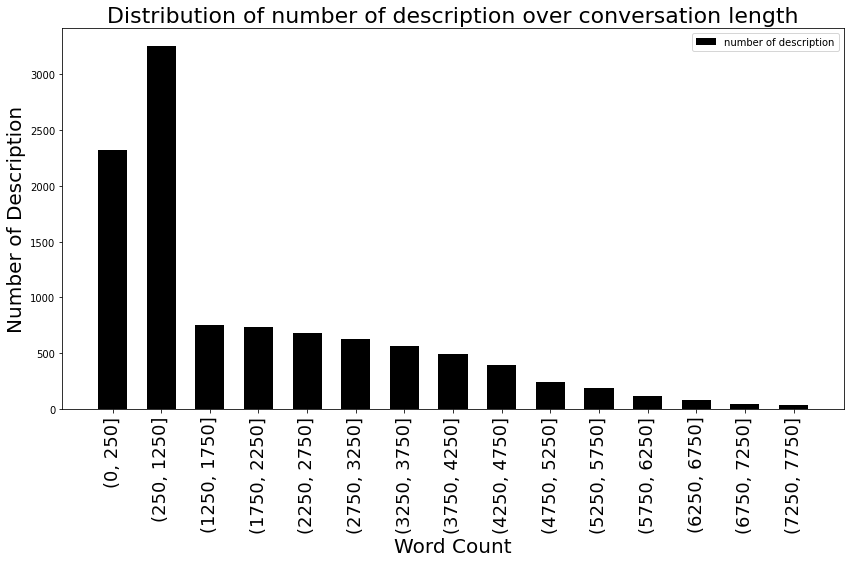

In [ ]:
number_list = grouped["Description"].tolist()

tick_label = grouped.index.tolist()

bar_width = 0.6
x = np.arange(15)

fig,ax = plt.subplots(1,1,figsize=(14,7))
rects1 = ax.bar(x, number_list, bar_width, label="number of description", color="black")

# add texts
ax.set_xlabel("Word Count", fontsize=20)
ax.set_ylabel("Number of Description", fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(tick_label, rotation=90, fontsize=18)
ax.set_title("Distribution of number of description over conversation length", fontsize=22)
ax.legend()
#save_fig("Distribution of number of description over sentence length")
plt.show()

### **2. Sentiment Rating**

In [ ]:
df["sentiment"] = df["lemma_str"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df.head()

,IP Address (hashed),ID,Case Number,Case Origin,Case Reason,Subject,Description,Break Confidentiality?,Main Issue Category,Issues mentioned,Initial Feeling,Age,County,Region,Gender,Sexuality,Ethnicity,Disabled,Religion,Employment Status,Date/Time Opened,How do they prefer help?,What type of help?,Were signposts offered?,Description1,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str,wordcount,sentiment
1,dbd57d182ed3da1ac3a97e166b31d077,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,58884,Webchat,help for themselves,depression and feeling suicidal,yp feeling suicidal difficulty emotional regul...,0,Mental Health,Debt; Depression/Low Mood; Feelings and Emotio...,Depressed,20,NaN,London,Female,Bisexual,White English/Welsh/Scottish/Northern Irish/Br...,No,No Religion,Student,2020/10/22,Chat; Email; Face to Face; Online,Counselling; Emotional Support,Yes,yp feeling suicidal difficulty emotional regul...,"[yp, feeling, suicidal, difficulty, emotional,...","[(yp, RB), (feeling, VBG), (suicidal, JJ), (di...","[(yp, r), (feeling, v), (suicidal, a), (diffic...","[yp, feel, suicidal, difficulty, emotional, re...",yp feel suicidal difficulty emotional regulati...,254,-0.025000
2,01f4a991f5c23ae9a7854c304a7600ed,a38298491bfe475e250829c22ee087a1bDpx,42333,Webchat,help for themselves,anxiety,yp waiting trauma team discuss past experience...,0,Mental Health,Anxiety; Emotional Abuse; Feelings and Emotions,Anxious; Down,15,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/2/19,Online,Not Sure,Yes,yp waiting trauma team discuss past experience...,"[yp, waiting, trauma, team, discuss, past, exp...","[(yp, RB), (waiting, VBG), (trauma, NN), (team...","[(yp, r), (waiting, v), (trauma, n), (team, n)...","[yp, wait, trauma, team, discus, past, experie...",yp wait trauma team discus past experience emo...,153,-0.262500
3,fa5cd7dbfa3b302b8e0457a577338496,25f693b8c960df27645a352d4120d042EWFK,43385,Webchat,help for themselves,lonely,yp lonely feels like suffocating referred chil...,0,Mental Health,Mental Health and Wellbeing; Sexuality/sexual ...,Lonely,18,Not Known,North East England,Male,NaN,Pakistani,NaN,NaN,NaN,2020/3/11,Chat; Online,Not Sure,Yes,yp lonely feels like suffocating referred chil...,"[yp, lonely, feels, like, suffocating, referre...","[(yp, NN), (lonely, RB), (feels, NNS), (like, ...","[(yp, n), (lonely, r), (feels, n), (like, n), ...","[yp, lonely, feel, like, suffocate, referred, ...",yp lonely feel like suffocate referred childli...,129,0.083333
4,ff08050e693ee76b9d14b297a4b6a4b0,527e102ad2ac164dffda3156aafa29aabBGx,43751,Webchat,help for themselves,suicidal thoughts,yp experiencing bad flashbacks abused child do...,0,Mental Health,Thoughts of suicide/suicidal ideation; Thought...,Depressed,24,Not Known,Yorkshire and the Humber,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/3/18,We didn?t ask,We didn?t ask,No,yp experiencing bad flashbacks abused child do...,"[yp, experiencing, bad, flashbacks, abused, ch...","[(yp, NN), (experiencing, VBG), (bad, JJ), (fl...","[(yp, n), (experiencing, v), (bad, a), (flashb...","[yp, experience, bad, flashback, abuse, child,...",yp experience bad flashback abuse child domest...,189,-0.150000
5,cbb1b36513d87e942423ca51a1e428fe,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,40587,Webchat,help for themselves,depressed,yp feeling depressed experienced physical abus...,0,Mental Health,Mental Health and Wellbeing; Physical Abuse,Alone,23,Not Known,East of England,Female,NaN,White English/Welsh/Scottish/Northern Irish/Br...,NaN,NaN,NaN,2020/1/15,Face to Face,Not Sure,Yes,yp feeling depressed experienced physical abus...,"[yp, feeling, depressed, experienced, physical...","[(yp, RB), (feeling, VBG), (depressed, VBN), (...","[(yp, r), (feeling, v), (depressed, v), (exper...","[yp, feel, depress, experienced, physical, abu...",yp feel depress experienced physical abuse mon...,215,0.183333


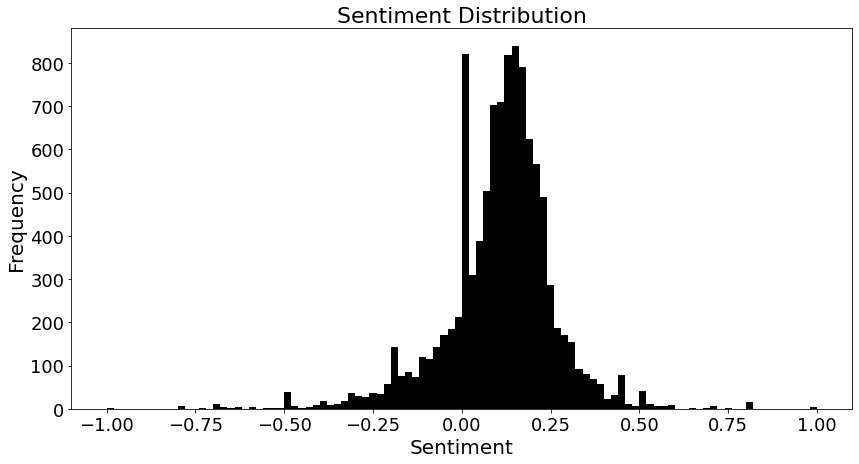

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,7))
plt.xlabel("Sentiment", fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel("Frequency", fontsize=20)
plt.yticks(fontsize=18)
plt.hist(df["sentiment"], bins=100, color="black")
plt.title("Sentiment Distribution", fontsize=22)
# save_fig("Sentiment Distribution")
plt.show()

In [ ]:
df["Break Confidentiality?"].value_counts()

0    10333
1      271
Name: Break Confidentiality?, dtype: int64

No handles with labels found to put in legend.


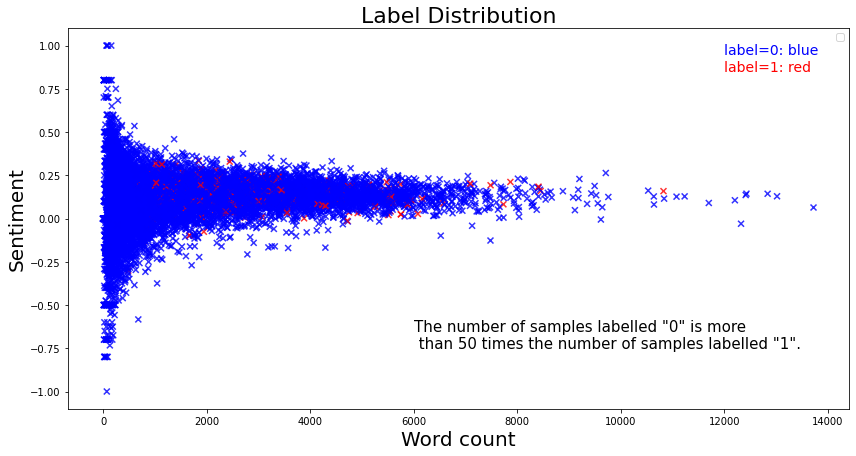

In [ ]:
x = df["wordcount"]
y = df["sentiment"]
colors = df["Break Confidentiality?"]

# fig, ax = plt.subplots(figsize=(14,7))
# for color in ["label=0: blue", "label=1: red"]:
#   ax.scatter(x, y, c=colors, alpha=0.8, marker="x", label=color, cmap="bwr")
#   ax.set_xlabel("Word count", fontsize=20)
#   ax.set_ylabel("Sentiment", fontsize=20)
#   ax.set_title("Label Distribution", fontsize=22)
#   ax.text(6000,-0.75,'The number of samples labelled "0" is more \n than 50 times the number of samples labelled "1".',fontsize=15, color = "k")
# ax.legend()

plt.figure(figsize = (14,7))
plt.scatter(x, y, c=colors, alpha=0.8, marker="x", cmap='bwr')
plt.xlabel("Word count", fontsize=20)
plt.ylabel("Sentiment", fontsize=20)
plt.title("Label Distribution", fontsize=22)
plt.text(6000,-0.75,'The number of samples labelled "0" is more \n than 50 times the number of samples labelled "1".',fontsize=15, color = "k")
plt.text(12000,0.95,'label=0: blue',fontsize=14, color = "blue")
plt.text(12000,0.85,'label=1: red',fontsize=14, color = "red")
plt.legend()
plt.show()

### **3. Term Frequency Analysis**

In [ ]:
# Create a bag of all words
words = df["lemmatized"]
all_words = []
for wordlist in words:
  all_words += wordlist

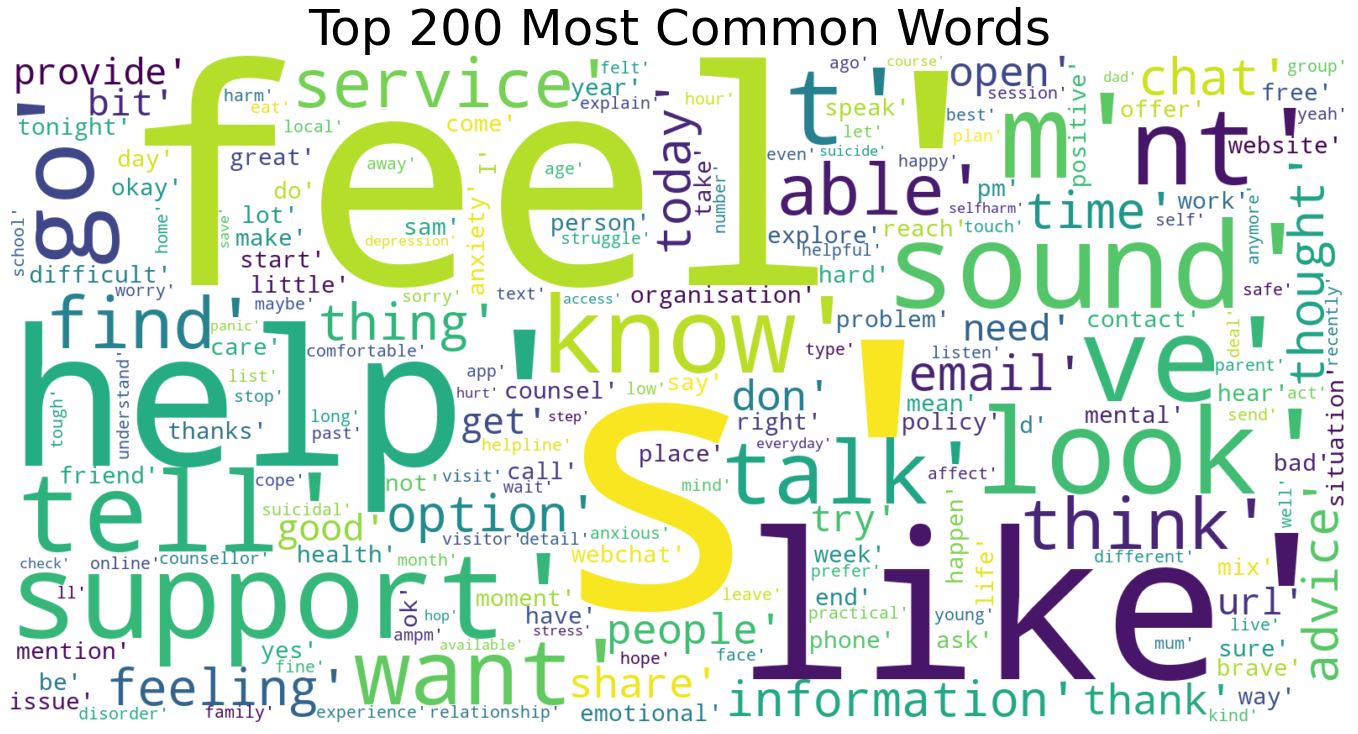

In [ ]:
mostcommon = FreqDist(all_words).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
# save_fig("Top 100 Most Common Words")
plt.show()

In [ ]:
# Look for negative words
df_negative = df[df["sentiment"]<-0.7]

In [ ]:
# Create a bag of all words
words_n = df_negative["lemmatized"]
all_words_n = []
for wordlist in words_n:
  all_words_n += wordlist

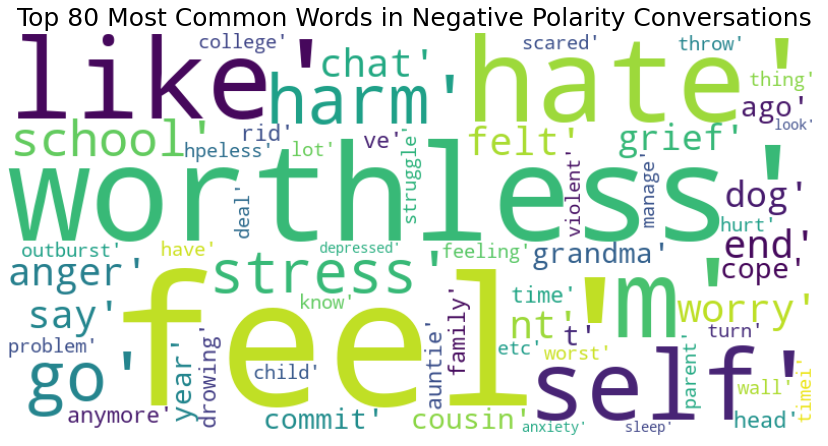

In [ ]:
mostcommon = FreqDist(all_words_n).most_common(80)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(15,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 80 Most Common Words in Negative Polarity Conversations', fontsize=25)
plt.tight_layout(pad=0)
# save_fig("Top 100 Most Common Words")
plt.show()

In [ ]:
# Look for negative words
df_positive = df[df["sentiment"]>0.6]

In [ ]:
# Create a bag of all words
words_p = df_positive["lemmatized"]
all_words_p = []
for wordlist in words_p:
  all_words_p += wordlist

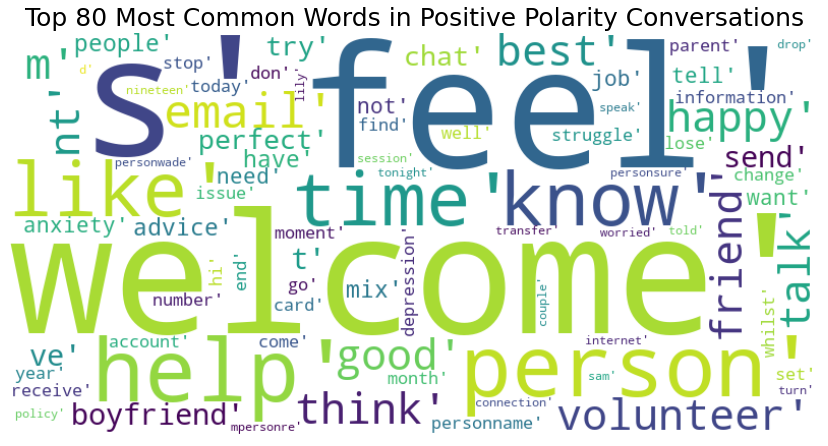

In [ ]:
mostcommon = FreqDist(all_words_p).most_common(80)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(15,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 80 Most Common Words in Positive Polarity Conversations', fontsize=25)
plt.tight_layout(pad=0)
# save_fig("Top 100 Most Common Words")
plt.show()

### **Information Extraction**

In [ ]:
# load english language model
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

text = "This is a sample sentence."

# create spacy 
doc = nlp(text)

for token in doc:
    print(token.text,'->',token.pos_)

This -> DET
is -> AUX
a -> DET
sample -> NOUN
sentence -> NOUN
. -> PUNCT


In [ ]:
df2 = df2[df2["wordcount"]!=0]
df2 = df2.reset_index()
df2 = df2.drop(columns = ["index"])

In [ ]:
df2

,ID,Description,wordcount,lemma_str
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feeling suicidal difficulty emotional regul...,254,yp feel suicidal difficulty emotional regulati...
1,a38298491bfe475e250829c22ee087a1bDpx,yp waiting trauma team discuss past experience...,153,yp wait trauma team discus past experience emo...
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feels like suffocating referred chil...,129,yp lonely feel like suffocate referred childli...
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experiencing bad flashbacks abused child do...,189,yp experience bad flashback abuse child domest...
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feeling depressed experienced physical abus...,215,yp feel depress experienced physical abuse mon...
...,...,...,...,...
10573,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person writing need help solve awful situation...,384,person write need help solve awful situation h...
10574,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl called nogeuira s send family porn...,156,person girl call nogeuira s send family porn v...
10575,25f693b8c960df27645a352d4120d042DpQT,information policies help today hi lately ive ...,2596,information policy help today hi lately I have...
10576,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issues start years ol...,976,mind help want form help issue start year old ...


In [ ]:
# I would like to work with shorther sentences
# So I get data3 with shorter sentences
df3 = df2[df2["wordcount"]<=250]
df3 = df3.reset_index()
df3 = df3.drop(columns = ["index"])

In [ ]:
df3

,ID,Description,wordcount,lemma_str
0,a38298491bfe475e250829c22ee087a1bDpx,yp waiting trauma team discuss past experience...,153,yp wait trauma team discus past experience emo...
1,25f693b8c960df27645a352d4120d042EWFK,yp lonely feels like suffocating referred chil...,129,yp lonely feel like suffocate referred childli...
2,527e102ad2ac164dffda3156aafa29aabBGx,yp experiencing bad flashbacks abused child do...,189,yp experience bad flashback abuse child domest...
3,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feeling depressed experienced physical abus...,215,yp feel depress experienced physical abuse mon...
4,527e102ad2ac164dffda3156aafa29aac6Bp,yp distressed news work home weeks isolation c...,50,yp distress news work home week isolation because
...,...,...,...,...
2321,ecfae00d73bee59fb711e3340ba19453HW2U,person applied councelling telephone couple da...,171,person apply councelling telephone couple day ...
2322,9b6b7a98af46bc546a6ef683eefb41bceH06,person embarrassed feel danger,30,person embarrass feel danger
2323,527e102ad2ac164dffda3156aafa29aabUPu,person cant find sleep streets,30,person can not find sleep street
2324,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl called nogeuira s send family porn...,156,person girl call nogeuira s send family porn v...


In [ ]:
# Write function that will generate random sentences from this dataframe
from random import randint
def rand_sent(df):
  index = randint(0, len(df))
  print('Index = ',index)
  doc = nlp(df.loc[index,'Sent'][1:])
  displacy.render(doc, style='dep',jupyter=True)
        
  return index

In [ ]:
# Finally, make a function to evaluate the result of our rule
# function to check output percentage for a rule
def output_per(df,out_col):
  result = 0
    
  for out in df[out_col]:
    if len(out)!=0:
      result+=1
    
  per = result/len(df)
  per *= 100
    
  return per

###**Rule on Adjective Noun Structure**

In [ ]:
# What we are looking to achieve here is – “better life”
# function for rule 2
def rule2(text):
    
    doc = nlp(text)

    pat = []
    
    # iterate over tokens
    for token in doc:
        phrase = ''
        # if the word is a subject noun or an object noun
        if (token.pos_ == 'NOUN')\
            and (token.dep_ in ['dobj','pobj','nsubj','nsubjpass']):
            
            # iterate over the children nodes
            for subtoken in token.children:
                # if word is an adjective or has a compound dependency
                if (subtoken.pos_ == 'ADJ') or (subtoken.dep_ == 'compound'):
                    phrase += subtoken.text + ' '
                    
            if len(phrase)!=0:
                phrase += token.text
             
        if  len(phrase)!=0:
            pat.append(phrase)
        
    
    return pat

In [ ]:
# create a df containing sentence and its output for rule 2
row_list = []

for i in range(len(df3)):
    
    sent = df3.loc[i,'lemma_str']
    year = df3.loc[i,'ID']
    # rule
    output = rule2(sent)
    
    dict1 = {'ID':id,'Sent':sent,'Output':output}
    row_list.append(dict1)

df_rule2 = pd.DataFrame(row_list)
# rule 1 achieves % result on simple sentences
output_per(df_rule2,'Output')

82.58813413585555

In [ ]:
# We can now try to check it on the entire corpus
# create a df containing sentence and its output for rule 2
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df2)):
    
    sent = df2.loc[i,'lemma_str']
    id = df2.loc[i,'ID']
    output = rule2(sent)
    dict1 = {'ID':id,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule2_all = pd.DataFrame(row_list)

# check rule output on complete speeches
output_per(df_rule2_all,'Output')

96.17129892229156

In [ ]:
# On the entire corpus, 95% sentences matched the pattern
# selecting non-empty outputs
df_show2 = pd.DataFrame(columns=df_rule2_all.columns)

for row in range(len(df_rule2_all)):
    
    if len(df_rule2_all.loc[row,'Output'])!=0:
        df_show2 = df_show2.append(df_rule2_all.loc[row,:])

# reset the index
df_show2.reset_index(inplace=True)
df_show2.drop('index',axis=1,inplace=True) 

In [ ]:
df_show2

,ID,Sent,Output
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res..."
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]"
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]"
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]"
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta..."
...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord..."
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo..."
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ..."
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl..."


In [ ]:
df_show2[["Output"]]

,Output
0,"[difficulty regulation depression, process res..."
1,"[team discus, bad history anorexia talk site]"
2,"[suffocate referred childline, muslim gay]"
3,"[bad violence relationship, bad connection]"
4,"[facetoface help, talk suggestedpersone, conta..."
...,...
10168,"[awful situation housemates, borderline disord..."
10169,"[person girl, family porn videos, fake faceboo..."
10170,"[policy help, tonight person, tell bit, share ..."
10171,"[mind help, help issue, best friend, old littl..."


### **Using Phrases to Track Sentiment Changes** 

In [ ]:
# Rename the dataframe
df_new = df_show2

# Change the list into a array
df_new["Output1"] = [','.join(map(str,l)) for l in df_new["Output"]]
df_new

,ID,Sent,Output,Output1
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res...","difficulty regulation depression,process resol..."
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]","team discus,bad history anorexia talk site"
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]","suffocate referred childline,muslim gay"
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]","bad violence relationship,bad connection"
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta...","facetoface help,talk suggestedpersone,contact gp"
...,...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord...","awful situation housemates,borderline disorder..."
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo...","person girl,family porn videos,fake facebook i..."
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ...","policy help,tonight person,tell bit,share soun..."
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl...","mind help,help issue,best friend,old little br..."


In [ ]:
count = []
for i in df_new["Output"]:
  count.append(len(i))

In [ ]:
count = np.array(count)

In [ ]:
df_new["count"]=count

In [ ]:
df_new

,ID,Sent,Output,Output1,count
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res...","difficulty regulation depression,process resol...",3
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]","team discus,bad history anorexia talk site",2
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]","suffocate referred childline,muslim gay",2
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]","bad violence relationship,bad connection",2
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta...","facetoface help,talk suggestedpersone,contact gp",3
...,...,...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord...","awful situation housemates,borderline disorder...",7
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo...","person girl,family porn videos,fake facebook i...",4
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ...","policy help,tonight person,tell bit,share soun...",41
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl...","mind help,help issue,best friend,old little br...",22


In [ ]:
df_new["count"].value_counts()

3      467
1      459
2      450
4      418
5      350
      ... 
259      1
215      1
175      1
140      1
223      1
Name: count, Length: 186, dtype: int64

In [ ]:
df_new

,ID,Sent,Output,Output1,count
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res...","difficulty regulation depression,process resol...",3
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]","team discus,bad history anorexia talk site",2
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]","suffocate referred childline,muslim gay",2
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]","bad violence relationship,bad connection",2
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta...","facetoface help,talk suggestedpersone,contact gp",3
...,...,...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord...","awful situation housemates,borderline disorder...",7
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo...","person girl,family porn videos,fake facebook i...",4
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ...","policy help,tonight person,tell bit,share soun...",41
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl...","mind help,help issue,best friend,old little br...",22


In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(sent):
  return TextBlob(sent).sentiment.subjectivity
  
# Create a function to get the polarity
def getPolarity(sent):
  return TextBlob(sent).sentiment.polarity

In [ ]:
subjectivity = []
for i in df_new["Output"]:
  sub = []
  for sent in i:
    result = getSubjectivity(sent)
    sub.append(result)
    sub = [round(i, 2) for i in sub]
  subjectivity.append(sub)

In [ ]:
df_new["Subjectivity"] = np.array(subjectivity)

df_new["Subjectivity"] = df_new["Subjectivity"]
df_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,ID,Sent,Output,Output1,count,Subjectivity
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res...","difficulty regulation depression,process resol...",3,"[0.0, 0.0, 0.0]"
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]","team discus,bad history anorexia talk site",2,"[0.0, 0.67]"
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]","suffocate referred childline,muslim gay",2,"[0.0, 0.58]"
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]","bad violence relationship,bad connection",2,"[0.67, 0.67]"
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta...","facetoface help,talk suggestedpersone,contact gp",3,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord...","awful situation housemates,borderline disorder...",7,"[1.0, 0.0, 0.0, 0.67, 0.0, 0.0, 0.0]"
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo...","person girl,family porn videos,fake facebook i...",4,"[0.0, 0.0, 1.0, 0.8]"
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ...","policy help,tonight person,tell bit,share soun...",41,"[0.0, 0.0, 0.0, 0.4, 0.83, 0.0, 0.0, 1.0, 1.0,..."
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl...","mind help,help issue,best friend,old little br...",22,"[0.0, 0.0, 0.3, 0.35, 0.0, 0.0, 0.0, 0.0, 0.95..."


In [ ]:
polarity = []
for i in df_new["Output"]:
  pol = []
  for sent in i:
    result = getPolarity(sent)
    pol.append(result)
    pol = [round(i, 2) for i in pol]
  polarity.append(pol)

In [ ]:
df_new["Polarity"] = np.array(polarity)

df_new["Polarity"] = df_new["Polarity"]
df_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,ID,Sent,Output,Output1,count,Subjectivity,Polarity
0,c4d6738a2e3a29fbc384c9389c2c626fEQdLE,yp feel suicidal difficulty emotional regulati...,"[difficulty regulation depression, process res...","difficulty regulation depression,process resol...",3,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
1,a38298491bfe475e250829c22ee087a1bDpx,yp wait trauma team discus past experience emo...,"[team discus, bad history anorexia talk site]","team discus,bad history anorexia talk site",2,"[0.0, 0.67]","[0.0, -0.7]"
2,25f693b8c960df27645a352d4120d042EWFK,yp lonely feel like suffocate referred childli...,"[suffocate referred childline, muslim gay]","suffocate referred childline,muslim gay",2,"[0.0, 0.58]","[0.0, 0.42]"
3,527e102ad2ac164dffda3156aafa29aabBGx,yp experience bad flashback abuse child domest...,"[bad violence relationship, bad connection]","bad violence relationship,bad connection",2,"[0.67, 0.67]","[-0.7, -0.7]"
4,27785f745b74fb8b2e9c95e7b0fbfbd1ac7h,yp feel depress experienced physical abuse mon...,"[facetoface help, talk suggestedpersone, conta...","facetoface help,talk suggestedpersone,contact gp",3,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
10168,c4d6738a2e3a29fbc384c9389c2c626fEQ25a,person write need help solve awful situation h...,"[awful situation housemates, borderline disord...","awful situation housemates,borderline disorder...",7,"[1.0, 0.0, 0.0, 0.67, 0.0, 0.0, 0.0]","[-1.0, 0.0, 0.0, -0.7, 0.0, 0.0, 0.0]"
10169,27785f745b74fb8b2e9c95e7b0fbfbd1Xzct,person girl call nogeuira s send family porn v...,"[person girl, family porn videos, fake faceboo...","person girl,family porn videos,fake facebook i...",4,"[0.0, 0.0, 1.0, 0.8]","[0.0, 0.0, -0.5, -0.2]"
10170,25f693b8c960df27645a352d4120d042DpQT,information policy help today hi lately I have...,"[policy help, tonight person, tell bit, share ...","policy help,tonight person,tell bit,share soun...",41,"[0.0, 0.0, 0.0, 0.4, 0.83, 0.0, 0.0, 1.0, 1.0,...","[0.0, 0.0, 0.0, 0.4, -0.39, 0.0, 0.0, 0.0, -0...."
10171,9b6b7a98af46bc546a6ef683eefb41bcdHQh,mind help want form help issue start year old ...,"[mind help, help issue, best friend, old littl...","mind help,help issue,best friend,old little br...",22,"[0.0, 0.0, 0.3, 0.35, 0.0, 0.0, 0.0, 0.0, 0.95...","[0.0, 0.0, 1.0, -0.04, 0.0, 0.0, 0.0, 0.0, 0.7..."


In [ ]:
type(df_new["Subjectivity"])

pandas.core.series.Series

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Saving figure line1


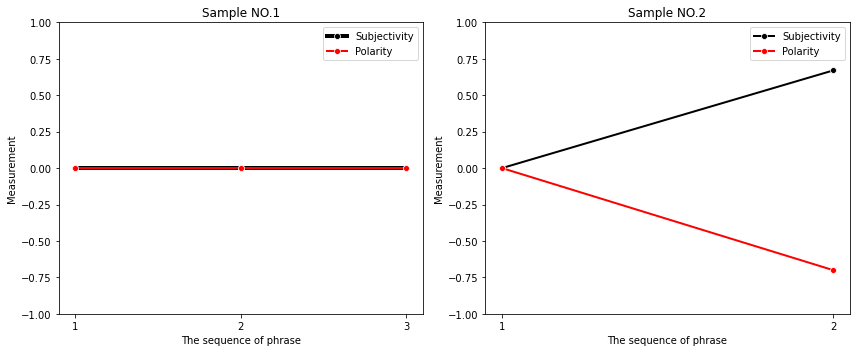

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={"width_ratios":[1,1]})

# Data 1
line1 = pd.DataFrame({'The sequence of phrase': range(1,4), 'Subjectivity': df_new["Subjectivity"][0], 'Polarity': df_new["Polarity"][0]})

# multiple line plots
from matplotlib.pyplot import MultipleLocator
ax1 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line1, marker='o', markerfacecolor='black', markersize=6, color='black', linewidth=4, linestyle="-",label="Subjectivity", ax=ax[0])
ax1 = sns.lineplot("The sequence of phrase", "Polarity", data=line1, marker='o', markerfacecolor='red', markersize=6, color='red', linewidth=2, label="Polarity", ax=ax[0])

x_major_locator=MultipleLocator(1)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.axis(ymin = -1, ymax = 1)
ax1.set_ylabel("Measurement")
ax1.set_title("Sample NO.1")

# Data 2
line2 = pd.DataFrame({'The sequence of phrase': range(1,3), 'Subjectivity': df_new["Subjectivity"][1], 'Polarity': df_new["Polarity"][1]})

# multiple line plots
ax2 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line2, marker='o', markerfacecolor='black', markersize=6, color='black', linewidth=2, linestyle="-", label="Subjectivity", ax=ax[1])
ax2 = sns.lineplot("The sequence of phrase", "Polarity", data=line2, marker='o', markerfacecolor='red', markersize=6, color='red', linewidth=2, label="Polarity", ax=ax[1])

x_major_locator=MultipleLocator(1)
ax2.xaxis.set_major_locator(x_major_locator)
ax2.axis(ymin = -1, ymax = 1)
ax2.set_ylabel("Measurement")
ax2.set_title("Sample NO.2")

save_fig("line1")
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Saving figure line2


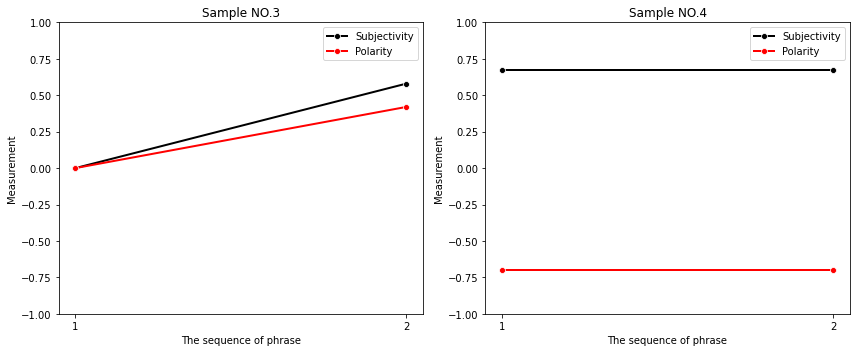

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={"width_ratios":[1,1]})
# Data 3
line3 = pd.DataFrame({'The sequence of phrase': range(1,3), 'Subjectivity': df_new["Subjectivity"][2], 'Polarity': df_new["Polarity"][2]})

# multiple line plots
ax1 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line3, marker='o', markerfacecolor='black', markersize=6, color='black', linewidth=2, linestyle="-", label="Subjectivity", ax=ax[0])
ax1 = sns.lineplot("The sequence of phrase", "Polarity", data=line3, marker='o', markerfacecolor='red', markersize=6, color='red', linewidth=2, label="Polarity", ax=ax[0])

x_major_locator=MultipleLocator(1)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.axis(ymin = -1, ymax = 1)
ax1.set_ylabel("Measurement")
ax1.set_title("Sample NO.3")

# Data 4
line4 = pd.DataFrame({'The sequence of phrase': range(1,3), 'Subjectivity': df_new["Subjectivity"][3], 'Polarity': df_new["Polarity"][3]})

# multiple line plots
ax2 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line4, marker='o', markerfacecolor='black', markersize=6, color='black', linewidth=2, linestyle="-", label="Subjectivity", ax=ax[1])
ax2 = sns.lineplot("The sequence of phrase", "Polarity", data=line4, marker='o', markerfacecolor='red', markersize=6, color='red', linewidth=2, label="Polarity", ax=ax[1])

x_major_locator=MultipleLocator(1)
ax2.xaxis.set_major_locator(x_major_locator)
ax2.axis(ymin = -1, ymax = 1)
ax2.set_ylabel("Measurement")
ax2.set_title("Sample NO.4")

save_fig("line2")
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Saving figure line3


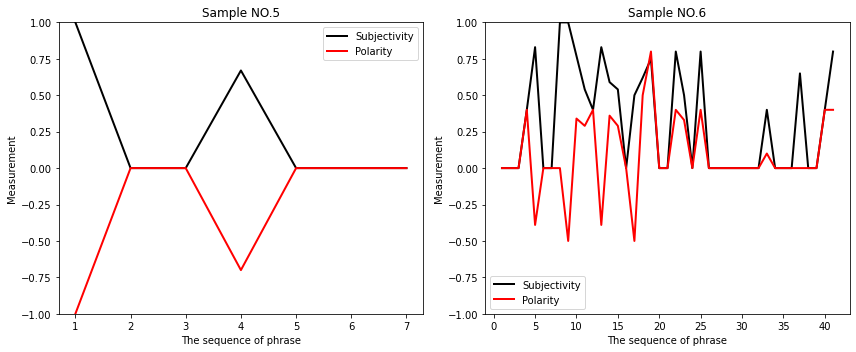

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={"width_ratios":[1,1]})
# Data 5
line5 = pd.DataFrame({'The sequence of phrase': range(1,8), 'Subjectivity': df_new["Subjectivity"][10168], 'Polarity': df_new["Polarity"][10168]})

# multiple line plots
ax5 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line5, color='black', linewidth=2, linestyle="-", label="Subjectivity", ax=ax[0])
ax5 = sns.lineplot("The sequence of phrase", "Polarity", data=line5, color='red', linewidth=2, label="Polarity", ax=ax[0])

x_major_locator=MultipleLocator(1)
ax5.xaxis.set_major_locator(x_major_locator)
ax5.axis(ymin = -1, ymax = 1)
ax5.set_ylabel("Measurement")
ax5.set_title("Sample NO.5")

# Data 6
line6 = pd.DataFrame({'The sequence of phrase': range(1,42), 'Subjectivity': df_new["Subjectivity"][10170], 'Polarity': df_new["Polarity"][10170]})

# multiple line plots
ax6 = sns.lineplot("The sequence of phrase", "Subjectivity", data=line6, color='black', linewidth=2, linestyle="-", label="Subjectivity", ax=ax[1])
ax6 = sns.lineplot("The sequence of phrase", "Polarity", data=line6, color='red', linewidth=2, label="Polarity", ax=ax[1])

x_major_locator=MultipleLocator(5)
ax6.xaxis.set_major_locator(x_major_locator)
ax6.axis(ymin = -1, ymax = 1)
ax6.set_ylabel("Measurement")
ax6.set_title("Sample NO.6")

save_fig("line3")
fig.show()


#### Maybe I should do sentiment analysis based on the adjective-noun structure: spliting the phrases into different columns and calculate the sentiment polarity for those phrases.